### Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
df = pd.read_csv('../data/HoChiMinh.csv')
df.head()

,Address,Datetime,DatetimeEpoch,Tempmax,Tempmin,Temp,Dew,Humidity,Precip,Precipprob,...,Windgust,Windspeed,Winddir,Pressure,Cloudcover,Visibility,Solarradiation,Solarenergy,Uvindex,Moonphase
0,Hồ Chí Minh,2019-01-01,1546275600,28.0,24.0,26.1,18.9,64.9,3.1,100.0,...,35.6,21.1,2.7,1012.2,59.8,10.3,72.0,6.3,4.0,0.83
1,Hồ Chí Minh,2019-01-02,1546362000,25.4,24.0,24.7,21.0,79.7,16.1,100.0,...,47.2,16.2,11.1,1011.7,61.5,9.4,52.4,4.5,3.0,0.87
2,Hồ Chí Minh,2019-01-03,1546448400,30.6,23.4,27.1,21.7,72.9,0.1,100.0,...,59.8,23.1,64.1,1011.9,58.6,10.1,154.4,13.3,6.0,0.90
3,Hồ Chí Minh,2019-01-04,1546534800,34.0,25.5,29.4,21.8,65.3,0.2,100.0,...,56.2,29.5,95.3,1012.5,43.4,10.3,209.4,18.2,7.0,0.94
4,Hồ Chí Minh,2019-01-05,1546621200,33.6,25.0,29.1,21.0,63.4,0.0,0.0,...,30.6,25.5,109.2,1012.3,32.6,10.3,233.9,20.2,8.0,0.97


### Chọn các đặc trưng có tương quan cao với `Temp` để đưa vào quá trình train model

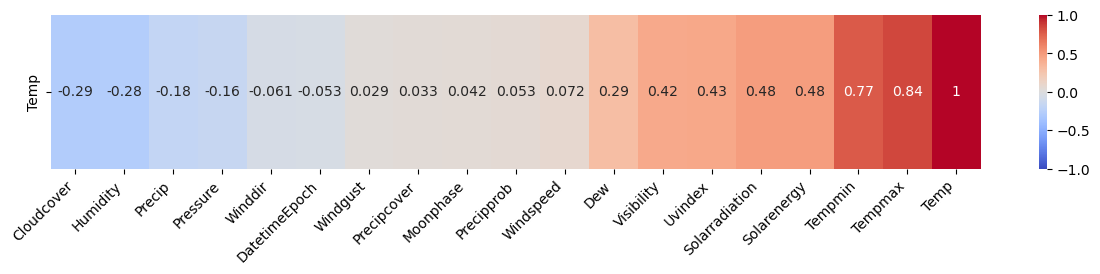

In [3]:
tmp = df.corr()['Temp'].sort_values()
plt.figure(figsize=(15, 2))
sns.heatmap(np.array(tmp)[:, None].T, annot=True, cmap='coolwarm',\
         vmin=-1, vmax=1, xticklabels=tmp.index, yticklabels=['Temp'])
plt.xticks(rotation=45, ha='right')
plt.show()

Dựa vào heatmap ở trên, chọn `threshold` là từ 0.25 - 0.75.

- Ngưỡng trên sẽ giúp loại bỏ các đặc trưng có tương quan quá cao, do đó giảm nguy cơ đa cộng tuyến trong mô hình hồi quy.

- Ngưỡng dưới đảm bảo rằng không loại bỏ các đặc trưng có mối liên hệ yếu với biến mục tiêu. Điều này giúp giữ lại các đặc trưng có thể đóng góp quan trọng vào dự đoán nhiệt độ.

In [4]:
threshold_u = 0.75
threshold_l = 0.25
target = 'Temp'
features = tmp[(np.abs(tmp) > threshold_l) & (np.abs(tmp) < threshold_u)].index
features

Index(['Cloudcover', 'Humidity', 'Dew', 'Visibility', 'Uvindex',
       'Solarradiation', 'Solarenergy'],
      dtype='object')

### Khởi tạo một số biến cần thiết

- `X`: tập đầu vào.

- `Y`: nhãn tương ứng.

- `benchmark`: 1 **dictionary** dùng để lưu lại các thông số của mô hình hồi quy, dùng cho việc so sánh các mô hình với nhau. Ở đây là bài toán hồi quy, do đó các độ đo được sử dụng sẽ là $MSE$ và $R^2$.

- `kf`: phương pháp kiểm tra là dùng K-Fold Cross Validation, với k=5.

In [5]:
X = df[features]
Y = df[target]

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

benchmark = {
    'Model': [],
    'Mean MSE': [],
    'Mean R2': [],
    'Elapsed': []
}
kf = KFold(n_splits=5, shuffle=True, random_state=182)

### Linear Regression

Linear Regression là một phương pháp hồi quy đơn giản để mô hình hóa mối quan hệ giữa một biến phụ thuộc (đầu ra) và một hoặc nhiều biến độc lập (đầu vào). Mô hình giả định rằng mối quan hệ giữa các biến là tuyến tính, tức là biến phụ thuộc có thể được ước tính bằng cách cộng các giá trị biến độc lập nhân với các hệ số (coefficients).

In [6]:
model = LinearRegression()
time_start = time.time()
mse_scores = cross_val_score(model, X_normalized, Y, cv=kf, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_normalized, Y, cv=kf, scoring='r2')
elapsed = time.time() - time_start
mse_scores = -mse_scores

benchmark['Model'].append('Linear Regression')
benchmark['Mean MSE'].append(np.mean(mse_scores))
benchmark['Mean R2'].append(np.mean(r2_scores))
benchmark['Elapsed'].append(elapsed)

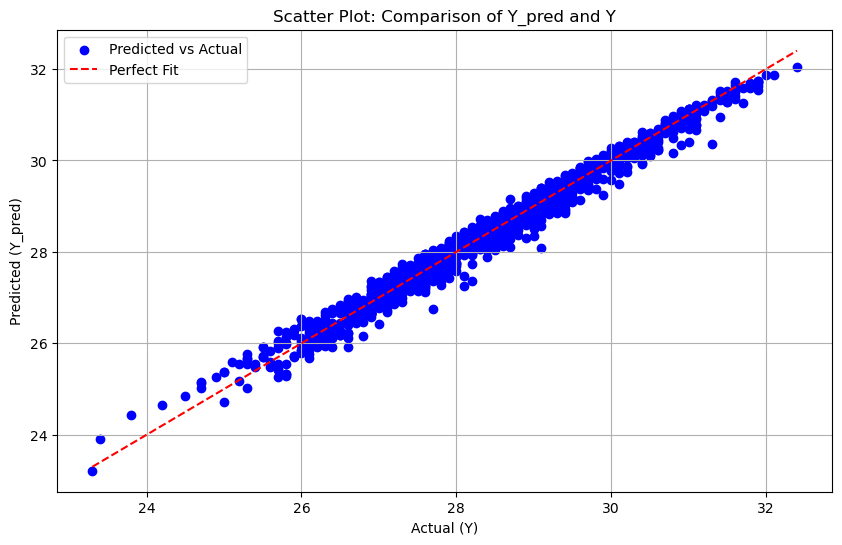

In [7]:
model.fit(X_normalized, Y)  
Y_pred = model.predict(X_normalized)  
plt.figure(figsize=(10, 6))
plt.scatter(Y, Y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual (Y)')
plt.ylabel('Predicted (Y_pred)')
plt.title('Scatter Plot: Comparison of Y_pred and Y')
plt.legend()
plt.grid(True)
plt.show()

### Random Forest Regression

Random Forest Regression là một thuật toán học máy dựa trên việc tạo ra một tập hợp các cây quyết định (decision trees) và sử dụng trung bình của kết quả từ tất cả các cây để đưa ra dự đoán. Mỗi cây trong rừng ngẫu nhiên được huấn luyện trên một mẫu ngẫu nhiên của dữ liệu và các đặc trưng ngẫu nhiên, giúp giảm thiểu overfitting và tăng độ chính xác. Số lượng cây trong rừng (`n_estimators`) thường được điều chỉnh dựa trên các bài toán khác nhau, và trong trường hợp này là 50, giúp đảm bảo một sự cân bằng giữa hiệu suất và tốc độ tính toán.

In [8]:
model = RandomForestRegressor(n_estimators=50, random_state=54321)
time_start = time.time()
mse_scores = cross_val_score(model, X_normalized, Y, cv=kf, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_normalized, Y, cv=kf, scoring='r2')
elapsed = time.time() - time_start
mse_scores = -mse_scores

benchmark['Model'].append('Random Forest Regression')
benchmark['Mean MSE'].append(np.mean(mse_scores))
benchmark['Mean R2'].append(np.mean(r2_scores))
benchmark['Elapsed'].append(elapsed)

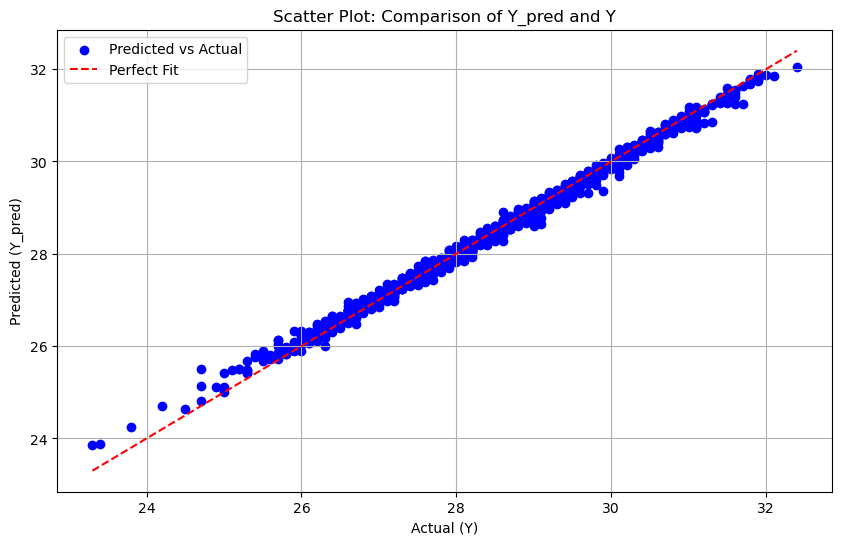

In [9]:
model.fit(X_normalized, Y)  
Y_pred = model.predict(X_normalized)  
plt.figure(figsize=(10, 6))
plt.scatter(Y, Y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual (Y)')
plt.ylabel('Predicted (Y_pred)')
plt.title('Scatter Plot: Comparison of Y_pred and Y')
plt.legend()
plt.grid(True)
plt.show()

### Polynomial Regression

Polynomial Regression là một mở rộng của hồi quy tuyến tính, nơi mối quan hệ giữa các biến được mô hình hóa dưới dạng một đa thức thay vì một đường thẳng. Trong Polynomial Regression với `degree`=2, mô hình sử dụng một đa thức bậc 2 để mô tả mối quan hệ giữa các biến. Phương pháp này có thể giúp cải thiện độ chính xác trong các bài toán khi mối quan hệ giữa các biến không phải là tuyến tính. Tuy nhiên, độ phức tạp của mô hình cũng tăng theo bậc của đa thức, có thể dẫn đến overfitting nếu không được điều chỉnh hợp lý.

In [10]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

scaler = StandardScaler()
X_poly_normalized = scaler.fit_transform(X_poly)

model = LinearRegression()

time_start = time.time()
mse_scores = cross_val_score(model, X_poly_normalized, Y, cv=kf, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_poly_normalized, Y, cv=kf, scoring='r2')
elapsed = time.time() - time_start
mse_scores = -mse_scores

benchmark['Model'].append('Polynomial Regression')
benchmark['Mean MSE'].append(np.mean(mse_scores))
benchmark['Mean R2'].append(np.mean(r2_scores))
benchmark['Elapsed'].append(elapsed)

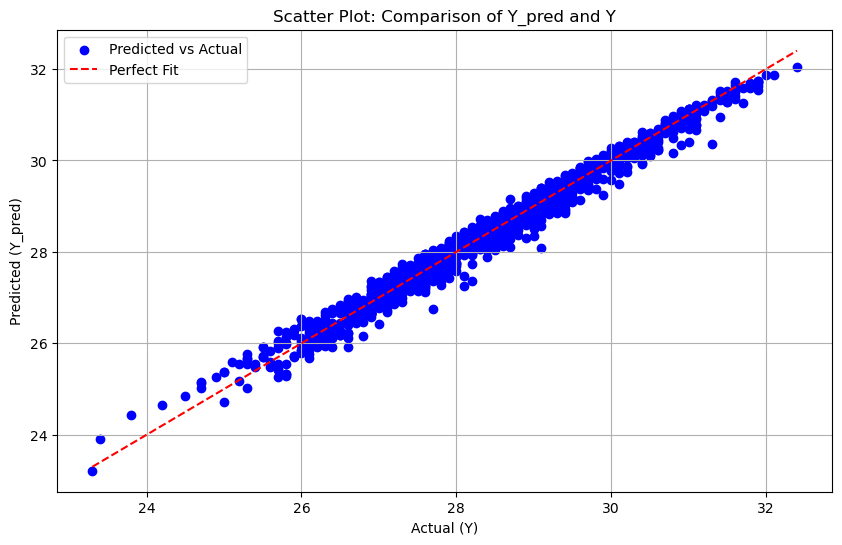

In [11]:
model.fit(X_normalized, Y)  
Y_pred = model.predict(X_normalized)  
plt.figure(figsize=(10, 6))
plt.scatter(Y, Y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual (Y)')
plt.ylabel('Predicted (Y_pred)')
plt.title('Scatter Plot: Comparison of Y_pred and Y')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
benchmark_df = pd.DataFrame(benchmark)
benchmark_df

,Model,Mean MSE,Mean R2,Elapsed
0,Linear Regression,0.035886,0.979854,0.019949
1,Random Forest Regression,0.082273,0.953295,2.011221
2,Polynomial Regression,0.015924,0.991075,0.109262


### Vẽ biểu đồ so sánh các mô hình

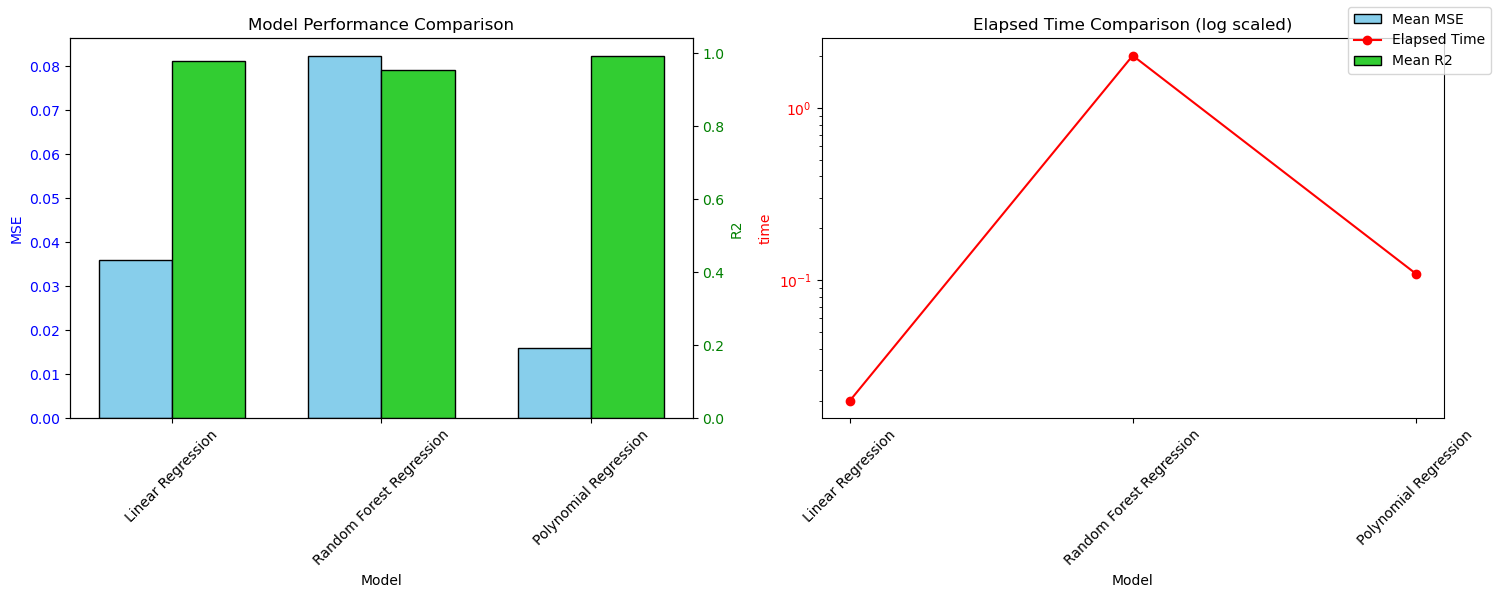

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

bar_width = 0.35
index = np.arange(len(benchmark_df))

bar1 = ax1.bar(index, benchmark_df['Mean MSE'], bar_width, label='Mean MSE', color='skyblue', edgecolor='black')
ax1.set_xlabel('Model')
ax1.set_ylabel('MSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(benchmark_df['Model'], rotation=45)

ax3 = ax1.twinx()
bar2 = ax3.bar(index + bar_width, benchmark_df['Mean R2'], bar_width, label='Mean R2', color='limegreen', edgecolor='black')
ax3.set_ylabel('R2', color='g')
ax3.tick_params(axis='y', labelcolor='g')
ax1.set_title('Model Performance Comparison')


ax2.plot(benchmark_df['Model'], benchmark_df['Elapsed'], marker='o', linestyle='-', color='red', label='Elapsed Time')
ax2.set_xlabel('Model')
ax2.set_ylabel('time', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_xticks(index)  
ax2.set_xticklabels(benchmark_df['Model'], rotation=45)
ax2.set_yscale('log')
ax2.set_title('Elapsed Time Comparison (log scaled)')

fig.legend()
fig.tight_layout()
plt.show()

### Nhận xét

- Dựa vào biểu đồ bên trái, ta thấy được các mô hình cho ra sai số khá thấp, cả 3 mô hình đều có $MSE$ < 0.1 và $R^2 \approx 1$.

- Dựa vào biểu đồ scatter của các mô hình, có thể thấy **Polynomial Regression** cho ra các điểm dự đoán sát đường thẳng $Y=X$ nhất (cho ra dự đoán sát thực tế nhất).

- Chi tiết hơn, **Random Forest Regression** có chỉ số $MSE$ hơi cao hơn 2 mô hình còn lại và $R^2$ tuy hơi nhỏ hơn nhưng không quá đáng kể, đồng thời cũng là mô hình có thời gian chạy lâu nhất. **Polynomial Regression** cho ra các kết quả khá tốt khi có $MSE$ thấp nhất cũng như $R^2$ khá cao. Tương tự với **Linear Regression** cũng cho ra các kết quả khá tốt.

- Nhìn chung, **Polynomial Regression** và **Linear Regression** có vẻ là 2 mô hình tốt nhất khi cho ra các kết quả khá tốt và thời gian chạy không quá lâu như **Random Forest Regression**.